<a href="https://colab.research.google.com/github/tejasr42/nma/blob/solutions/W2D1_Tutorial4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NMA 2020 W2D1 -- Tutorial 4: Marginalization & Fitting to data

**Tutorial Lecturer:** *Konrad Kording*

**Tutorial Content Creator:** *Vincent Valton*

### a. Introduction


Video available at https://youtube.com/watch?v=sB5003XOKdw


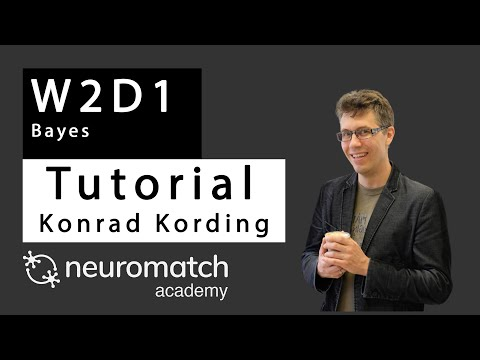

In [1]:
#@title Video 1
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='sB5003XOKdw', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

---

### Tutorial objectives
  
In this notebook, we'll have a look at computing the marginalization matrix and the marginal in order to perform model inversion. This will let us recover the model parameters for a participant, using their experimental data.  

The generative model will be the same Bayesian model we have been using throughout: a mixture of Gaussian prior and Gaussian likelihood..

Steps:

* First, we'll create the model, just as in Tutorial 2. It contains:
  1. A mixture of Gaussian prior matrix
  2. A likelihood matrix
  3. A posterior matrix
  4. A binary decision matrix
  
* Next, we'll perform the model inversion/fitting:
  5. Create an input matrix
  6. Implement the marginalization matrix
  7. Generate some data using the generative model provided
  8. Perform model inversion (model fitting) using the generated data and see if you recover the orignal parameters.


---
Please execute the cell below to initialize the notebook environment

---
### Setup

In [2]:
# Imports
import numpy as np                 # import numpy

import matplotlib.pyplot as plt    # import matplotlib
import matplotlib as mpl
from scipy.optimize import minimize    

In [3]:
#@title Figure Settings
%matplotlib inline
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'

In [4]:
# @title Helper Functions

def my_gaussian(x_points, mu, sigma):
    """
    Returns un-normalized Gaussian estimated at points `x_points`, with parameters: `mu` and `sigma`
    
    Args :
      x_points (numpy arrays of floats)- points at which the gaussian is evaluated
      mu (scalar) - mean of the Gaussian
      sigma (scalar) - std of the gaussian

    Returns: 
      un-normalized Gaussian (i.e. without constant) evaluated at `x`
    """
    return np.exp(-(x_points-mu)**2/(2*sigma**2))

def moments_myfunc(x_points, function):
  """
  DO NOT EDIT THIS FUNCTION !!!

  Returns the mean, median and mode of an arbitrary function

  Args : 
    x_points (numpy array of floats) - x-axis values
    function (numpy array of floats) - y-axis values of the function evaluated at `x_points`

  Returns:
    (tuple of 3 scalars): mean, median, mode
  """
  
  # Calc mode of arbitrary function
  mode = x_points[np.argmax(function)]

  # Calc mean of arbitrary function
  mean = np.sum(x_points * function)

  # Calc median of arbitrary function
  cdf_function = np.zeros_like(x_points)
  accumulator = 0
  for i in np.arange(x.shape[0]):
    accumulator = accumulator + function[i]
    cdf_function[i] = accumulator
  idx = np.argmin(np.abs(cdf_function - 0.5))
  median = x_points[idx]

  return mean, median, mode

def plot_mymatrix(matrix, xlabel, ylabel, title):
  """ Plot a matrix with labels.

  Args : 
    matrix (numpy array of floats) 
    xlabel (string) - label of x-axis
    ylabel (string) - label of y-axis
    title  (string) - title of plot

  Returns:
    None
  """
  fig_w, fig_h = plt.rcParams["figure.figsize"]
  fig = plt.figure(figsize=(fig_w, fig_h))
  
  ax = fig.add_subplot(111)
  ax.imshow(matrix)
  ax.set_xlabel(xlabel)
  ax.set_title(title)
  ax.set_ylabel(ylabel)
  ax.set_aspect('auto')
  return None

def plot_my_bayes_model(model) -> None:
  """Pretty-print a simple Bayes Model (ex 7), defined as a function:

  Args:
    - model: function that takes a single parameter value and returns 
             the negative log-likelihood of the model, given that parameter
  Returns: 
    None, draws plot
    """
  x = np.arange(-10,10,0.07)

  # Plot neg-LogLikelihood for different values of alpha
  alpha_tries = np.arange(0.01,0.3,0.01)
  nll = np.zeros_like(alpha_tries)
  for i_try in np.arange(alpha_tries.shape[0]):
    nll[i_try] = model(np.array([alpha_tries[i_try]]))

  fig_w, fig_h = plt.rcParams["figure.figsize"]
  fig = plt.figure(figsize=(fig_w, fig_h))
  plt.plot(alpha_tries, nll)
  plt.xlabel('alpha value')
  plt.ylabel('negative log-likelihood')

  # Mark minima
  ix = np.argmin(nll)
  plt.scatter(alpha_tries[ix], nll[ix], c='r', s=144)

  #plt.axvline(alpha_tries[np.argmin(nll)])
  plt.title('Sample Output')
  plt.show()

  return None


def plot_simulated_behavior(true_stim, behaviour):
  fig = plt.figure(figsize=(fig_w*1.2, fig_h*1.5))
  ax = fig.add_subplot(1,1,1)
  ax.set_facecolor('xkcd:light grey')
  plt.plot(true_stim, true_stim - behaviour, '-k', linewidth=2, label='data')
  plt.axvline(0, ls='dashed', color='grey')
  plt.axhline(0, ls='dashed', color='grey')
  plt.legend()
  plt.xlabel('Position of true visual stimulus (cm)')
  plt.ylabel('Participant deviation from true stimulus (cm)')
  plt.title('Participant behavior')
  plt.show()

  return None

---
## b. Implement a mixture of Gaussian prior

As in Tutorial 2, we want to create a prior matrix consisting of a mixture of Gaussians prior.

Using the equation for the un-normalised Gaussian `my_gaussian`:
* Generate a Gaussian with mean 0 and standard deviation 0.5
* Generate another Gaussian with mean 0 and standard deviation 10
* Combine the two Gaussians to make a new prior by mixing the two Gaussians with mixing parameter alpha = 0.05. Make it such that the peakier Gaussian has 95% of the weight (don't forget to normalize afterwards)
* This will be the first row of your prior matrix
* Now repeat (hint: use np.tile) that row prior to make a matrix of 1,000 (i.e. `hypothetical_stim.shape[0]`)  row-priors.
* Plot the matrix using the function `plot_mymatrix()` already pre-written and commented-out in your script

**Helper function(s)**

In [5]:
help(my_gaussian)

Help on function my_gaussian in module __main__:

my_gaussian(x_points, mu, sigma)
    Returns un-normalized Gaussian estimated at points `x_points`, with parameters: `mu` and `sigma`
    
    Args :
      x_points (numpy arrays of floats)- points at which the gaussian is evaluated
      mu (scalar) - mean of the Gaussian
      sigma (scalar) - std of the gaussian
    
    Returns: 
      un-normalized Gaussian (i.e. without constant) evaluated at `x`



In [6]:
help(plot_mymatrix)

Help on function plot_mymatrix in module __main__:

plot_mymatrix(matrix, xlabel, ylabel, title)
    Plot a matrix with labels.
    
    Args : 
      matrix (numpy array of floats) 
      xlabel (string) - label of x-axis
      ylabel (string) - label of y-axis
      title  (string) - title of plot
    
    Returns:
      None



### Exercise 1

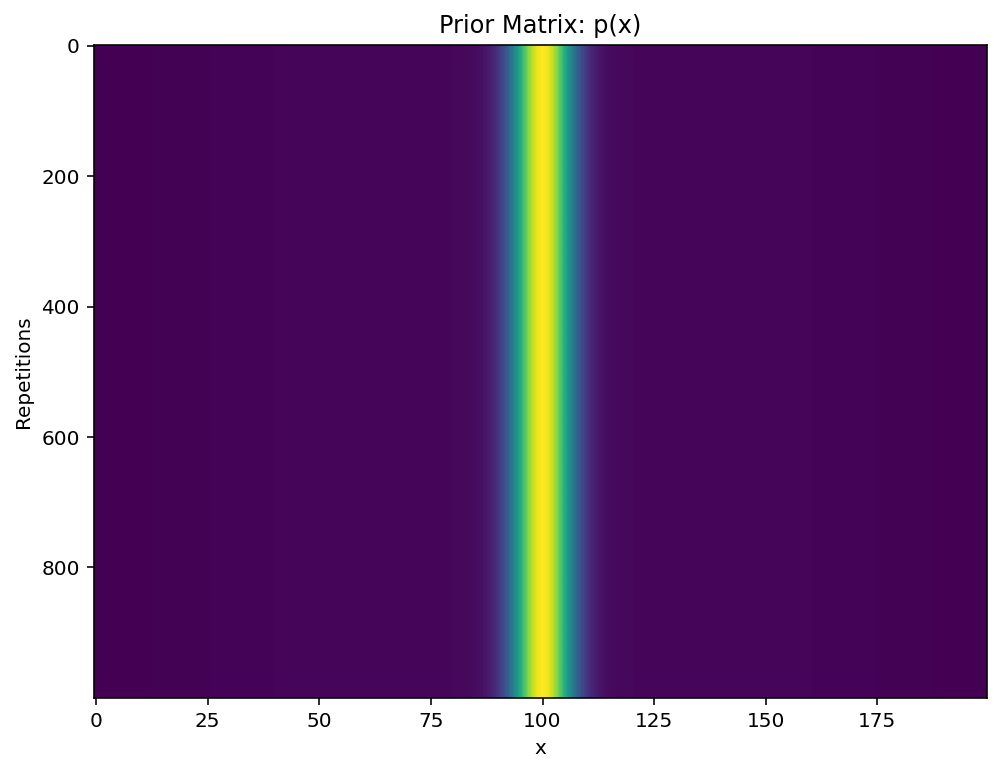

In [15]:
hypothetical_stim = np.linspace(-8, 8, 1000)
x = np.arange(-10, 10, 0.1)

##################
## Insert your code here to:
##       - Generate a mixture of gaussian prior with mean 0 and std 0.5 and 10 respectively
##       - Tile that row prior in order to make a matrix of 1000 row priors
##         (Hint: use np.tile() and np.reshape())
## When you are done, uncomment the line below to plot the prior matrix
##################
a=my_gaussian(x,0,0.5)
#a/=a.sum()
b=my_gaussian(x,0,10)
#b/=b.sum()
m=0.95*a+0.05*b
m/=m.sum()
prior_matrix=np.tile(m,[1000,1])
plot_mymatrix(prior_matrix, 'x', 'Repetitions', 'Prior Matrix: p(x)')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial4_Solution_4f33bda9.py)

*Example output:*

<img alt='Solution hint' align='left' width=517 height=406 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial4_Solution_4f33bda9_0.png>



---
## c. Implement a likelihood matrix
    
We now want to create a likelihood matrix that contains a Gaussian on each row of the matrix. Each row represents a different hypothetically presented stimulus with a different stimulus location. Therefore, each row of the likelihood matrix will have a different mean.

  Using the equation for the un-normalised Gaussian `my_gaussian` and the values in `hypothetical_stim`:
* Create a Gaussian likelihood with mean varying from `hypothetical_stim`, keeping $\sigma$ constant at 1.
* Each Likelihood with a different mean will make up a different row-likelihood of your matrix, such that you end up with a Likelihood matrix made up of 1,000 row-Gaussians with different means. (_Hint_: `np.tile` won't work here. You may need a for-loop).
* Plot the matrix using the function `plot_mymatrix()` already pre-written and commented-out in your script

###Exercise 2

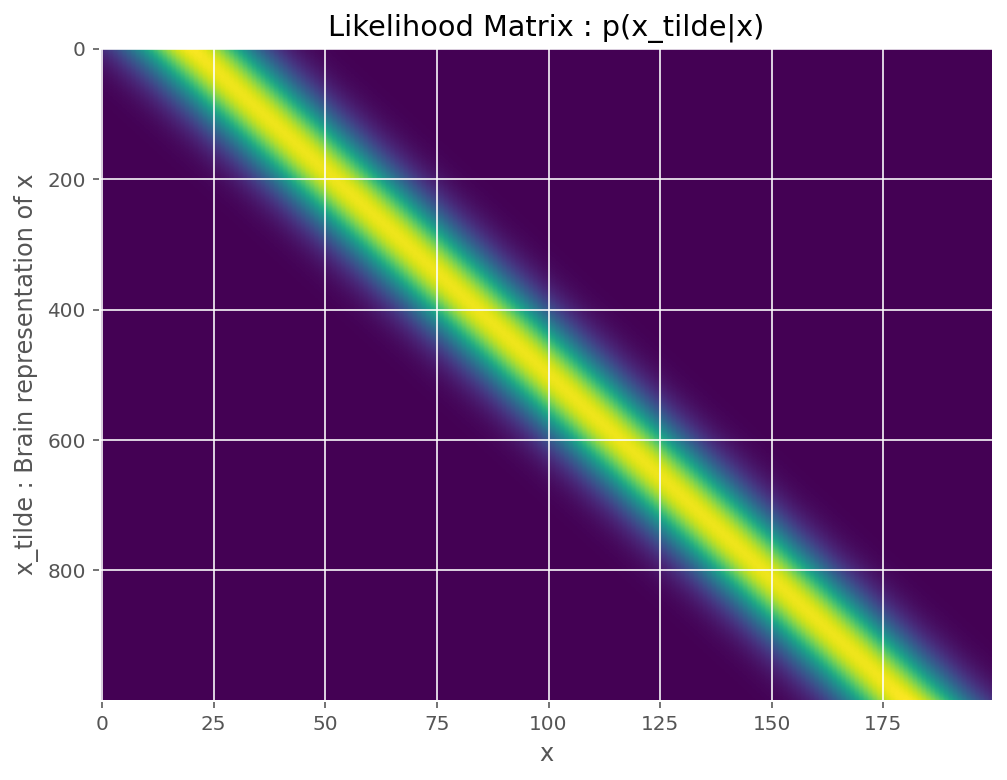

In [76]:
likelihood_matrix = np.zeros_like(prior_matrix)

#####################################################################################
## Insert your code here to:
##       - Generate a likelihood matrix using `my_gaussian` function, with sigma = 1,
##         and varying the mean using `hypothetical_stim` values.
##       - Plot the likelihood Matrix using the code snippet commented-out below
####################################################################################
for i,j in enumerate(hypothetical_stim):
  likelihood_matrix[i]=my_gaussian(x,j,1)
likelihood_matrix/=likelihood_matrix.sum(axis=1,keepdims=True)
plot_mymatrix(likelihood_matrix, 'x', 'x_tilde : Brain representation of x', 'Likelihood Matrix : p(x_tilde|x)')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial4_Solution_759ee48a.py)

*Example output:*

<img alt='Solution hint' align='left' width=517 height=407 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial4_Solution_759ee48a_0.png>



---
## d. Implement the posterior matrix
    
We now want to create the posterior matrix. To do so, we will compute the posterior using *Bayes rule* for each trial (i.e. row-wise). That is, each row of the posterior matrix will be the posterior resulting from the multiplication of the prior and likelihood of the equivalent row.

Mathematically:

\begin{eqnarray}
    Posterior\left[i, :\right] \propto Likelihood\left[i, :\right] \odot Prior\left[i, :\right]
\end{eqnarray}

where $\odot$ represents the [Hadamard Product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) (i.e., elementwise multiplication) of the corresponding prior and likelihood row vectors `i` from each matrix.

Follow these steps to build the posterior matrix:
* For each row (trial) of the prior and likelihood matrix, fill in the posterior matrix so that every row of the posterior matrix represents the posterior density for a different trial.
* Plot the matrix using the function `plot_mymatrix()` already pre-written and commented-out in your script

Optional:
* Do you need to operate on one element--or even one row--at a time? NumPy operations can often process an entire matrix in a single "vectorized" operation. This approach is often much faster and much easier to read than an element-by-element calculation.  Try to write a vectorized version that calculates the posterior without using any for-loops. _Hint_: look at `np.sum` and its keyword arguments.

###Exercise 3

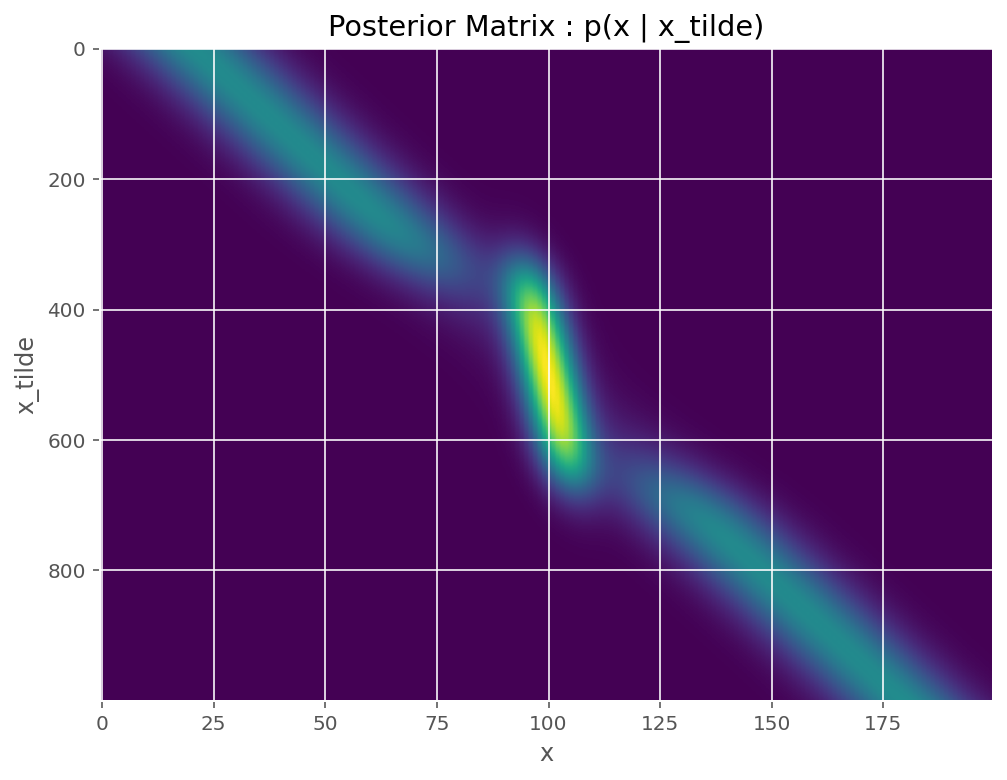

In [61]:
posterior_matrix = np.zeros_like(likelihood_matrix)

###############################################################################
## Insert your code here to:
##        For each row of the Prior & Likelihood Matrices, calculate the resulting posterior 
##        Fill the Posterior Matrix with the row_posterior
##        Plot the Posterior Matrix using the code snippet provided below
## When you are done, uncomment the last line to visualize your result
###############################################################################
posterior_matrix=np.multiply(likelihood_matrix,prior_matrix)
posterior_matrix/=posterior_matrix.sum(axis=1,keepdims=True)
plot_mymatrix(posterior_matrix, 'x', 'x_tilde', 'Posterior Matrix : p(x | x_tilde)')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial4_Solution_5efa5849.py)

*Example output:*

<img alt='Solution hint' align='left' width=517 height=407 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial4_Solution_5efa5849_0.png>



---
## e. Implement the binary decision matrix
    
We now want to create the binary decision matrix. To do so, we will scan the posterior matrix (i.e. row-wise), and set the matrix cell to 1 at the mean of the row posterior.

This effectively encodes the *decision* that a participant may make on a given trial (i.e., a row). In this case, the modelled decision rule is to take the mean of the posterior on each trial (use the function `moments_myfunc()` provided to calculate the mean of the posterior).

**Suggestions**
* For each row (trial) of the posterior matrix, calculate the mean of the posterior, and set the corresponding cell of the binary decision matrix to 1. (e.g., if the mode of the posterior is at position 0, then set the cell with x_column == 0 to 1).
* Plot the matrix using the function `plot_mymatrix()` already pre-written and commented-out in your script

**Helper function(s)**

In [ ]:
help(moments_myfunc)

Help on function moments_myfunc in module __main__:

moments_myfunc(x_points, function)
    DO NOT EDIT THIS FUNCTION !!!
    
    Returns the mean, median and mode of an arbitrary function
    
    Args : 
      x_points (numpy array of floats) - x-axis values
      function (numpy array of floats) - y-axis values of the function evaluated at `x_points`
    
    Returns:
      (tuple of 3 scalars): mean, median, mode



### Exercise 4

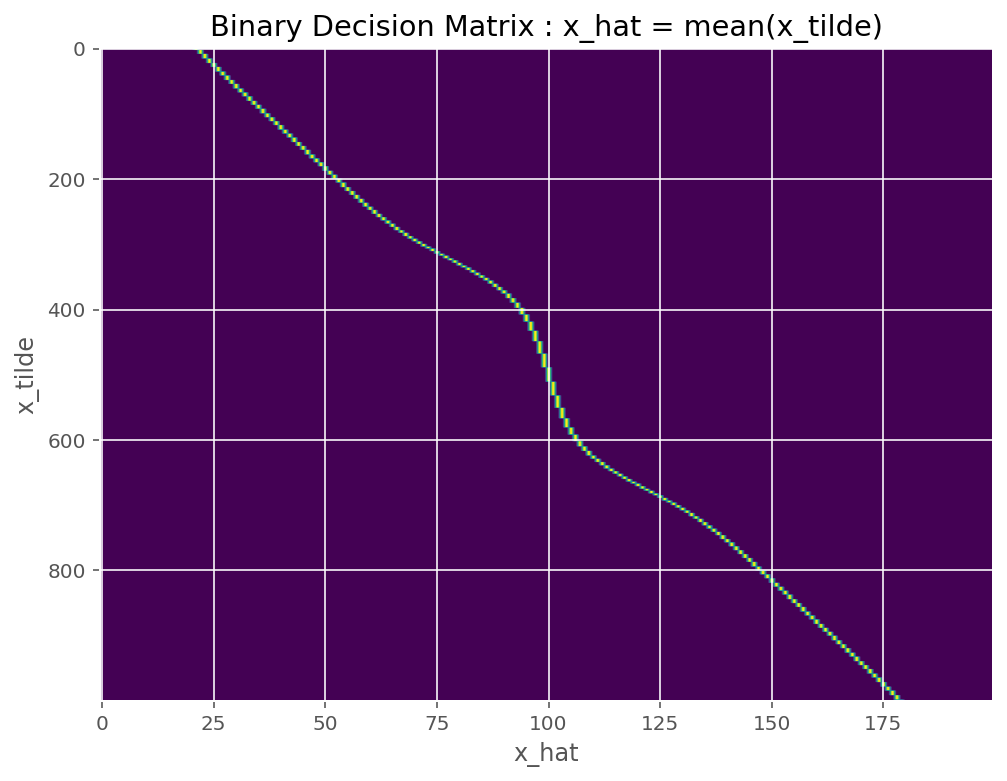

In [69]:
binary_decision_matrix = np.zeros_like(posterior_matrix)

################################################################################
## Insert your code here to:
##        Create a matrix of the same size as the Posterior matrix and fill it with zeros (Hint: use np.zeros_like())
##        For each row of the Posterior Matrix, calculate the mean of the posterior using the function povided `moments_myfunc()`, and set the corresponding cell of the Binary Decision Matrix to 1. 
##        Plot the binary decision matrix using the function `plot_mymatrix()` and the code snippet provided below
################################################################################
mean= np.expand_dims(posterior_matrix@x.T,1)
binary_decision_matrix[np.arange(posterior_matrix.shape[0]),np.abs(np.tile(x,[1000,1])-mean).argmin(axis=1)]=1
plot_mymatrix(binary_decision_matrix, 'x_hat', 'x_tilde', 'Binary Decision Matrix : x_hat = mean(x_tilde)')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial4_Solution_72f49503.py)

*Example output:*

<img alt='Solution hint' align='left' width=517 height=427 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial4_Solution_72f49503_0.png>



---
## f. Implement the input matrix

Video available at https://youtube.com/watch?v=ZlZOPnQXaJM


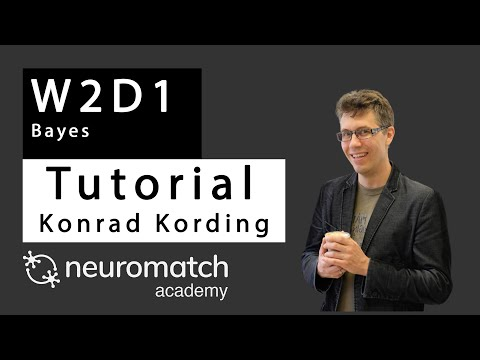

In [ ]:
#@title Video 2
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='ZlZOPnQXaJM', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

We now want to create the input matrix from the true presented stimulus. That is, we will now create a Gaussian centered around the true presented stimulus, with sigma = 1. and repeat that gaussian distribution across x values. That is we want to make a *column* gaussian centered around the true presented stimulus, and repeat this *column* Gaussian across all values of the x-axis matrix.

This, effectively encodes the distribution of the true stimulus (one single simulus) for that a participant on a given trial. 

**Suggestions**

For this exercise, we will assume the true stimulus is presented at direction -2.5
* Create a Gaussian likelihood with mean = -2.5 and $\sigma$ of 1.
* Make this the first column of your matrix and repeat that *column* to fill in the True_Presented_Stimulus matrix.
* Plot the matrix using the function `plot_mymatrix()` already pre-written and commented-out in your script

###Exercise 5

(1000,)


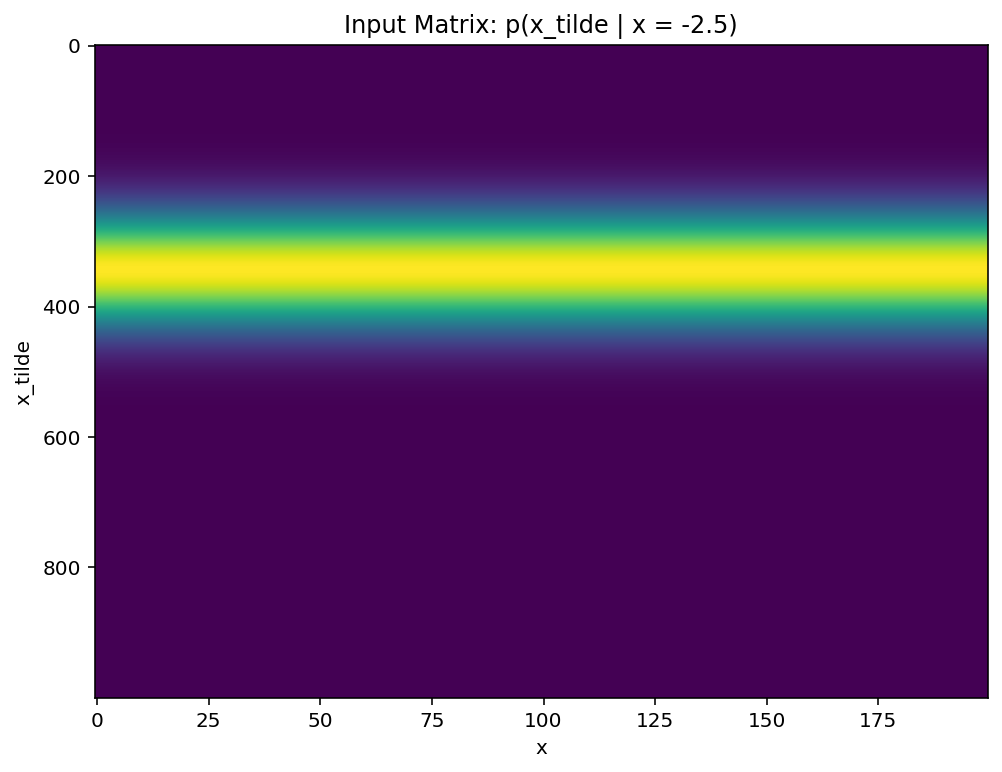

In [56]:
input_matrix = np.zeros_like(posterior_matrix)

################################################################################
## Insert your code here to:
##      - Generate a gaussian centered on the true stimulus -2.5 with sigma = 1
##      - Tile that column input Gaussian in order to complete the matrix
##         (Hint: use np.tile() and np.reshape())
##      - Plot the matrix using the code snippet commented-out below
################################################################################
m=my_gaussian(hypothetical_stim,-2.5,1)
m/=m.sum()
print(m.shape)
m=m.reshape(1000,1)
input_matrix=np.tile(m,[1,200])
plot_mymatrix(input_matrix, 'x', 'x_tilde', 'Input Matrix: p(x_tilde | x = -2.5)')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial4_Solution_1a8512fe.py)

*Example output:*

<img alt='Solution hint' align='left' width=517 height=407 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial4_Solution_1a8512fe_0.png>



---
## g. Implement the marginalization matrix

Video available at https://youtube.com/watch?v=gj3wrqFIERU


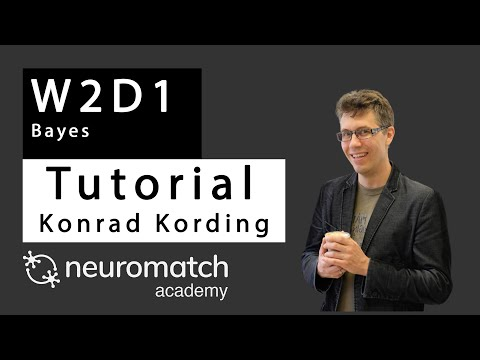

In [ ]:
#@title Video 3
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='gj3wrqFIERU', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

We now want to compute the marginalization matrix from the true presented stimulus, and our binary decision matrix over hypothetical stimulus inputs. 

Mathematically, this means that we want to compute:

\begin{eqnarray}
    Marginalization Matrix = Input Matrix \odot Binary Matrix
\end{eqnarray}

\begin{eqnarray}
    Marginal = \int_{x} Marginalization Matrix
\end{eqnarray}

**Suggestions**

* For each row of the input and binary matrix, calculate product of the two and fill in the Marginal matrix.
* Plot the matrix using the function `plot_mymatrix()` already pre-written and commented-out in your script
* Calculate and plot the marginal over `x` using the code snippet commented out in your script
   - Note how the limitations of numerical integration create artifacts on your marginal 

###Exercise 6

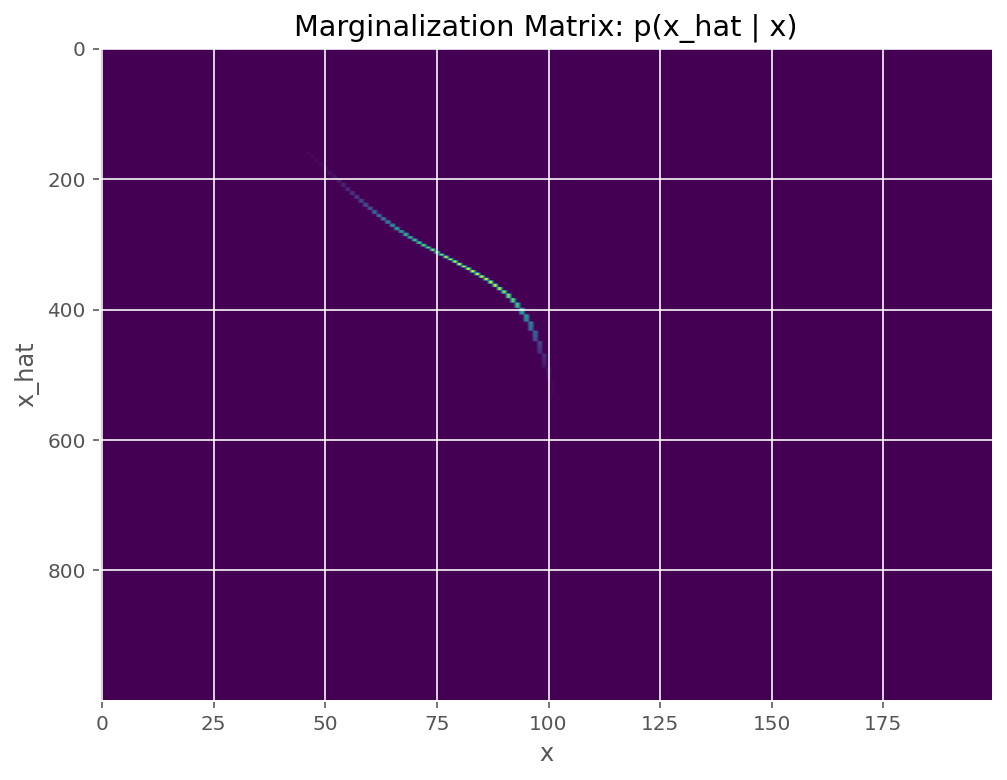

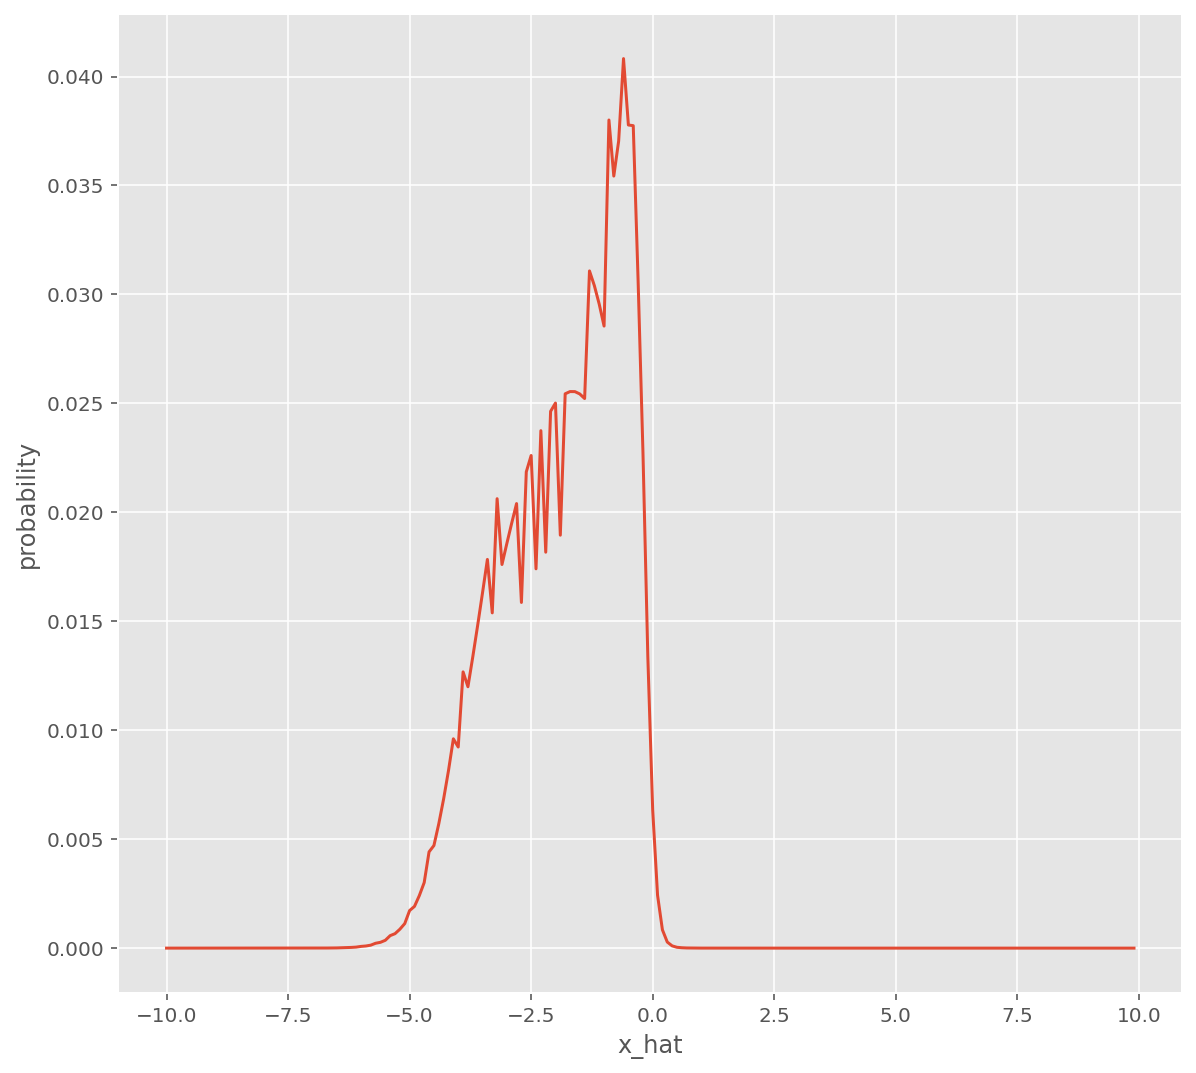

In [58]:
marginalization_matrix = np.zeros_like(posterior_matrix)

################################################################################
## Insert your code here to:
##      - Compute the Marginalization matrix by multiplying pointwise the Binary
##           decision matrix over hypothetical stimuli and the Input Matrix
##      - Compute the Marginal from the Marginalization matrix by summing over x (hint: use np.sum())
##      - Plot the Marginalization Matrix and the resulting Marginal using the code snippet provided below
################################################################################
marginalization_matrix=np.multiply(binary_decision_matrix,input_matrix)
plot_mymatrix(marginalization_matrix, 'x', 'x_hat', 'Marginalization Matrix: p(x_hat | x)')
marginal=marginalization_matrix.sum(axis=0)
plt.figure(figsize=(fig_w*1.192, fig_h*1.5))
plt.style.use('ggplot')
plt.plot(x, marginal)
plt.xlabel('x_hat')
plt.ylabel('probability')
plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial4_Solution_85e90658.py)

*Example output:*

<img alt='Solution hint' align='left' width=517 height=406 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial4_Solution_85e90658_0.png>

<img alt='Solution hint' align='left' width=615 height=569 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial4_Solution_85e90658_1.png>



---
## h. Generate some data


Now that we've seen how to calculate the posterior and marginalize to get $p(\hat{x} \mid x)$, we will generate some artificial data for a single participant using the `generate_data()` function provided, and mixing parameter $\alpha$ = 0.1. 

Our goal in the next exercise will be to recover that parameter. These parameter recovery experiments are a powerful method for planning and debugging Bayesian analyses--if you cannot recover the given parameters, something has gone wrong!

Please run the code below to generate some synthetic data.  You do not need to edit anything, but check that the plot below matches what you would expect from the video. 

### Run the data generating function.

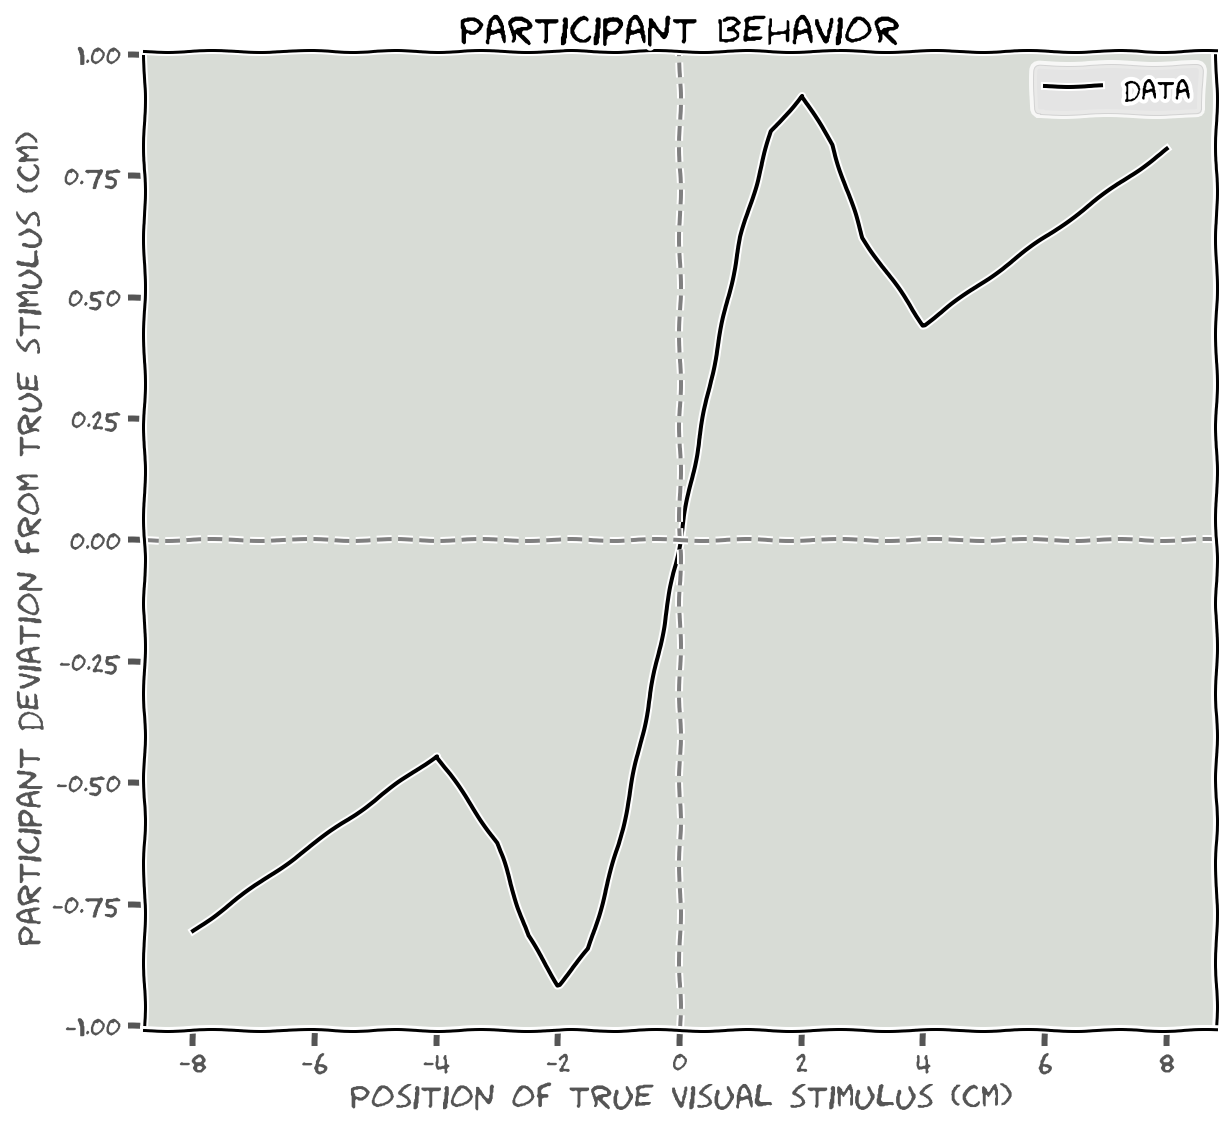

In [77]:
#@ title Generating Data
def generate_data(x_stim, alpha):
  """
  DO NOT EDIT THIS FUNCTION !!!

  Returns generated data using the mixture of Gaussian prior with mixture parameter `alpha`

  Args : 
    x_stim (numpy array of floats) - x values at which stimuli are presented
    alpha (scalar) - mixture component for the Mixture of Gaussian prior

  Returns:
    (numpy array of floats): x_hat response of participant for each stimulus
  """
  x = np.arange(-10,10,0.1)
  x_hat = np.zeros_like(x_stim)

  prior_mean = 0
  prior_sigma1 = .5
  prior_sigma2 = 3
  prior1 = my_gaussian(x, prior_mean, prior_sigma1)
  prior2 = my_gaussian(x, prior_mean, prior_sigma2)

  prior_combined = (1-alpha) * prior1 + (alpha * prior2) 
  prior_combined = prior_combined / np.sum(prior_combined)

  for i_stim in np.arange(x_stim.shape[0]):
    likelihood_mean = x_stim[i_stim]
    likelihood_sigma  = 1
    likelihood = my_gaussian(x, likelihood_mean, likelihood_sigma)
    likelihood = likelihood / np.sum(likelihood)

    posterior = np.multiply(prior_combined, likelihood)
    posterior = posterior / np.sum(posterior)
    
    # Assumes participant takes posterior mean as 'action'
    x_hat[i_stim] = np.sum(x * posterior)
  return x_hat

# Generate data for a single participant
true_stim = np.array([-8, -4, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 4, 8])
behaviour = generate_data(true_stim, 0.10)
with plt.xkcd():
  plot_simulated_behavior(true_stim, behaviour)

---
## i. Model fitting to generated data

Video available at https://youtube.com/watch?v=LhbkYoKbrhg


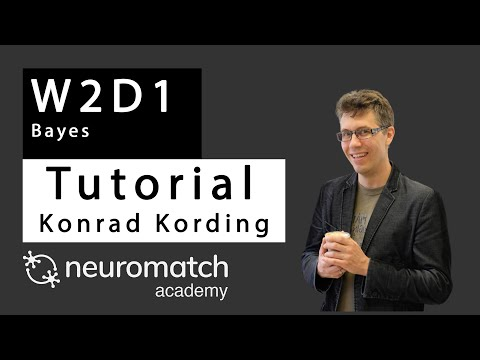

In [ ]:
#@title Video 4
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='LhbkYoKbrhg', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Now that we have generated some data, we will attempt to recover the parameter $\alpha$ that was used to generate it.

We have provided you with an incomplete function called `my_Bayes_model_mse()` that needs to be completed to perform the same computations you have performed in the previous exercises but over all the participant's trial, as opposed to a single trial.

The likelihood has already been constructed; since it depends  only on the hypothetical stimuli, it will not change. However, we will have to implement the prior matrix, since it depends on $\alpha$. We will therefore have to recompute the posterior, input and the marginal in order to get $p(\hat{x} \mid x)$. 

Using $p(\hat{x} \mid x)$, we will then compute the negative log-likelihood for each trial and find the value of $\alpha$ that minimizes the negative log-likelihood (i.e. maximises the log-likelihood.  See the model fitting tutorial from W1D3 for a refresher).

In this experiment, we assume that trials are independent from one another. This is a common assumption--and it's often even true! It allows us to define negative log-likelihood as:

\begin{eqnarray}
    -LL = - \sum_i \log p(\hat{x}_i \mid x_i)
\end{eqnarray}

where $\hat{x}_i$ is the participant's response for trial $i$, with presented stimulus $x_i$ 

* Complete the function `my_Bayes_model_mse`, to calculate the prior, posterior, input and marginalization matrix on each trial
* Compute the marginal using the marginalization matrix on each trial
* Compute the negative log likelihood using the marginal and the participant's response
* Using the code snippet commented out in your script to loop over possible values of $\alpha$


###Exercise 7

In [ ]:
def my_Bayes_model_mse(params):
  """
  Function fits the Bayesian model from Tutorial 3 
  
  Args : 
    params (list of positive floats):  parameters used by the model (params[0]  = posterior scaling)
            
  Returns :
    (scalar) negative log-likelihood :sum of log probabilities
  """
  
  trial_ll = np.zeros_like(true_stim)

  ##############################################################################
  ## Insert your code here to:
  ##        Compute the Prior matrix given `alpha`
  ##        Compute the Posterior matrix
  ##        Compute the Binary decision matrix
  ##############################################################################
  
  # Loop over stimuli
  for i_stim in np.arange(true_stim.shape[0]):
    
    ############################################################################
    ## Insert your code here to:
    ##      - Compute the Input matrix 
    ##      - Compute the Marginalization matrix
    ##      - Compute the Marginal
    ##      - Compute and return the negative log likelihood of the participant
    ##  When you're done, 
    ##      - comment out the line below and,
    ##      - enable plot_my_bayes_model on the line after it
    ############################################################################
    #raise NotImplementedError("You need to complete this function!")

#plot_my_bayes_model(my_Bayes_model_mse)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W2D1_BayesianStatistics/solutions/W2D1_Tutorial4_Solution_62e92b1e.py)

*Example output:*

<img alt='Solution hint' align='left' width=529 height=406 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W2D1_BayesianStatistics/static/W2D1_Tutorial4_Solution_62e92b1e_0.png>



## j. Summary

Video available at https://youtube.com/watch?v=vOlYbQehx-I


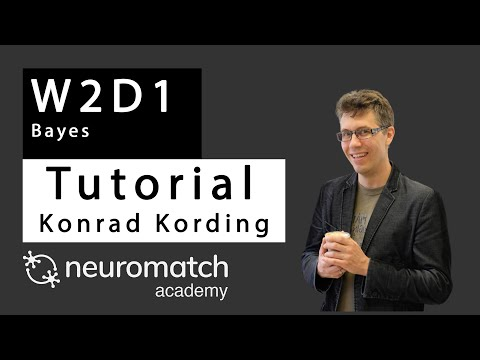

In [ ]:
#@title Video 5
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='vOlYbQehx-I', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Congratuations! You found $\alpha$, the parameter that describes how much weight subjects assign to the same-cause vs. independent-cause origins of a sound. In the preceeding notebooks, we went through the entire Bayesian analysis pipeline:

*   developing a model
*   choosing a cost function,
*   simulating data, and
*   using Bayes' Rule and marginalization to recover a hidden parameter from the data

This example was simple, but the same princples can be used to analyze datasets with many hidden variables and complex priors and likelihoods. Bayes' Rule will also play a cruical role in many of the other techniques you will see later this week. 